In [1]:
%matplotlib inline

## Load SDSS sample

In [2]:
from cosmodc2.sdss_colors import load_umachine_processed_sdss_catalog
sdss = load_umachine_processed_sdss_catalog()
print(sdss.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['ra', 'dec', 'z', 'sm', 'ssfr', 'nd', 'restframe_extincted_sdss_abs_magr', 'restframe_extincted_sdss_gr', 'restframe_extincted_sdss_ri', 'size_kpc', 'dr7_PhotoObj_Table_ID', 'sfr_percentile_fixed_sm', 'gr_percentile_fixed_magr']


## Load $z=0$ baseline ${\rm UniverseMachine}$ mock with $M_{\ast}\ \&\ {\rm SFR}$

In [3]:
import os
dirname = "/Users/aphearin/work/random/0330/testing_mock"
basename = "sfr_catalog_1.000000_value_added.hdf5"
fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')

#  Impute sSFR=0 values in the quenched sequence for plotting convenience
mock['obs_ssfr'] = mock['obs_sfr']/mock['obs_sm']
zero_mask = mock['obs_ssfr'] == 0
num_zeros = np.count_nonzero(zero_mask)
mock['obs_ssfr'][zero_mask] = 10**np.random.normal(loc=-13, scale=0.25, size=num_zeros)

print(mock.keys())

['halo_id', 'upid', 'vpeak', 'mpeak', 'mvir', 'vmax', 'sm', 'sfr', 'obs_sm', 'obs_sfr', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'hostid', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_sfr_percentile', 'sfr_percentile', 'obs_ssfr']


## Load ${\rm protoDC2\ v3}$ at $z=0$

In [4]:
dirname = "/Users/aphearin/Dropbox/protoDC2/umachine_z0p1_color_mock"
basename = "umachine_z0p1_color_mock.hdf5"
fname = os.path.join(dirname, basename)
from astropy.table import Table
v3_mock = Table.read(fname, path='data')
print(v3_mock.keys())

['id', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'obs_sm', 'obs_sfr', 'mpeak', 'mvir', 'vmax', 'vmax_at_mpeak', 'upid', 'hostid', 'has_matching_host', 'host_halo_x', 'host_halo_y', 'host_halo_z', 'host_halo_vx', 'host_halo_vy', 'host_halo_vz', 'host_halo_mvir', 'host_centric_x', 'host_centric_y', 'host_centric_z', 'host_centric_vx', 'host_centric_vy', 'host_centric_vz', 'obs_ssfr', 'sfr_percentile_fixed_sm', 'rmag', 'sdss_petrosian_gr', 'sdss_petrosian_ri', 'size_kpc', 'dr7_photoobj_id']


##  Assign Absolute r-band magnitude

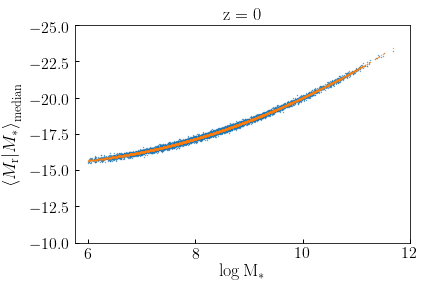

In [52]:
from cosmodc2.sdss_colors import median_magr_from_mstar

median_magr = median_magr_from_mstar(
    np.log10(mock['obs_sm']), x_table=[8.5, 10, 11.5], y_table=[-17.75, -20., -23])


mock['restframe_extincted_sdss_abs_magr'] = np.random.normal(
    loc=median_magr, scale=0.1, size=len(mock))
fig, ax = plt.subplots(1, 1)

nskip = 300
__=ax.scatter(np.log10(mock['obs_sm'][::nskip]), 
              mock['restframe_extincted_sdss_abs_magr'][::nskip], s=0.1)
__=ax.scatter(np.log10(mock['obs_sm'][::nskip]), median_magr[::nskip], s=0.1)
ylim = ax.set_ylim(-10, -25)
xlim = ax.set_xlim(5.75, 12)
xlabel = ax.set_xlabel(r'${\rm \log M_{\ast}}$')
ylabel = ax.set_ylabel(r'${\langle M_{\rm r}\vert M_{\ast}\rangle}_{\rm median}$')
title = ax.set_title(r'${\rm z=0}$')

## Compare cumulative number density to Zehavi+11

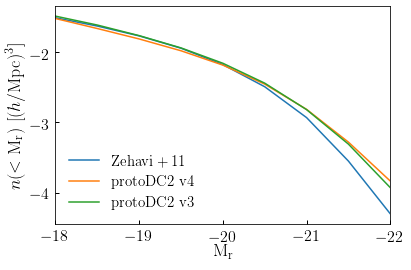

In [53]:
from cosmodc2.sdss_colors import zehavi11_cumulative_nd
lumthresh_h1p0, cumnd_sdss = zehavi11_cumulative_nd()

from cosmodc2.mock_diagnostics import cumulative_nd

volume_v4 = 250.**3.
protoDC2_littleh = 0.7
cumnd_pdc2_v4 = cumulative_nd(mock['restframe_extincted_sdss_abs_magr'], 
                           volume_v4, protoDC2_littleh, lumthresh_h1p0)
volume_v3 = 250.**3.
cumnd_pdc2_v3 = cumulative_nd(v3_mock['rmag'], 
                           volume_v3, protoDC2_littleh, lumthresh_h1p0)





fig, ax = plt.subplots(1, 1)

__=ax.plot(lumthresh_h1p0, np.log10(cumnd_sdss), label=r'${\rm Zehavi+11}$')
__=ax.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v4), label=r'${\rm protoDC2\ v4}$')
__=ax.plot(lumthresh_h1p0, np.log10(cumnd_pdc2_v3), label=r'${\rm protoDC2\ v3}$')

legend = ax.legend()
xlabel = ax.set_xlabel(r'${\rm M_{r}}$')
ylabel = ax.set_ylabel(r'$n(<{\rm M_r})\ [(h/{\rm Mpc})^3]$')

xlim = ax.set_xlim(-18, -22)

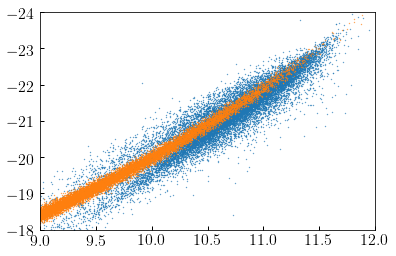

In [65]:
fig, ax = plt.subplots(1, 1)

nskip_sdss = 10
__=ax.scatter(sdss['sm'][::nskip_sdss], 
              sdss['restframe_extincted_sdss_abs_magr'][::nskip_sdss], s=0.1)

nskip_mock = 50
__=ax.scatter(np.log10(mock['obs_sm'][::nskip_mock]), 
              mock['restframe_extincted_sdss_abs_magr'][::nskip_mock], s=0.1)

ylim = ax.set_ylim(-18, -24)
xlim = ax.set_xlim(9, 12)

In [ ]:
# from halotools.empirical_models import polynomial_from_table

# def magr_from_mstar(log_mstar, x_table = [8, 10, 11.5], 
#                     y_table = [-16.25, -19.8, -23]):
#     """
#     """
#     return polynomial_from_table(x_table, y_table, log_mstar)

# fig, ax = plt.subplots(1, 1)


# nskip = 20
# __=ax.scatter(np.log10(v3_mock['obs_sm'][::nskip]), v3_mock['rmag'][::nskip], s=0.1)

# x = np.linspace(6, 12, 100)
# __=ax.plot(x, magr_from_mstar(x), color='k')

# ylim = ax.set_ylim(-18, -24.5)
# xlim = ax.set_xlim(10., 12)


In [ ]:
# sm_low, sm_high = 11.4, 11.6
# sm_mask = (v3_mock['obs_sm'] > 10**sm_low) & (v3_mock['obs_sm'] < 10**sm_high)
# np.median(v3_mock['rmag'][sm_mask])